In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import numpy as np
from PIL import Image
import os

In [2]:
VOCAB_SIZE = 30000
MAX_LEN = 256

In [3]:
TOKENIZER_SAVEDIR = Path('/home/macosta/ttmp/primus-data/cropped/cropped-txt-tokenizer/')
LM_MODEL_SAVEDIR = Path('/home/macosta/ttmp/primus-models/gpt2-lm-columnwise/')
TXT_FILES = Path('/home/macosta/ttmp/primus-data/cropped/cropped-txt/')

In [4]:
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LEN,
    n_head=12,
)

In [5]:
model = GPT2LMHeadModel(config=config).from_pretrained(str(LM_MODEL_SAVEDIR))

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_SAVEDIR, max_len=MAX_LEN)

file /home/macosta/ttmp/primus-data/cropped/cropped-txt-tokenizer/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def tokens_to_image(tokens):
    tokens = [t for t in tokens if t[0] != '<']
    img_array = np.zeros((len(tokens[0]), len(tokens)), dtype=np.uint8)
    for j, column in enumerate(tokens):
        for i, char in enumerate(column):
            img_array[i, j] = (1-int(char)) * 255
    img = Image.fromarray(img_array)
    return img

In [9]:
def continue_image(file, seed_length=100, pred_length=500, max_len=128, show=True, show_original=True, temp=1):
    with open(file, 'r') as f:
        data = f.read()
    tokens = data.split()
    index = int(np.random.random()*(len(tokens) - seed_length))
    seed = tokens[index:index + seed_length]
    if show_original:
        tokens_to_image(seed).show()
    input_string = f"{' '.join(seed[-(max_len - 1):])}"
    inputs = tokenizer.encode(input_string, return_tensors="pt")
    output_tokens = model.generate(inputs, 
                                   min_length=seed_length, 
                                   max_length=max_len, 
                                   pad_token_id=50256,
                                   temperature=temp,
                                   num_beams=5)[0]
    output_tokens = tokenizer.decode(output_tokens).split()
    img = tokens_to_image(output_tokens)
    img.show()
    return img

In [8]:
def generate_image(show=False):
    input_str = torch.tensor([[4]])
    output_tokens = model.generate(input_str, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   max_length=MAX_LEN,
                                   do_sample=True)[0]
    output_tokens = tokenizer.decode(output_tokens).split()
    if output_tokens[0] == '<s>':
        output_tokens = output_tokens[1:]
    img = tokens_to_image(output_tokens)
    if show:
        img.show()
    return img

In [44]:
def generate_images(n, savepath):
    savepath.mkdir(exist_ok=True)
    for i in tqdm(range(n)):
        img = generate_image()
        img.save(savepath / f"generated-columnwise-{i}.png")

In [42]:
def generate_until_end_token(max_extend=512):
    input_tensors = torch.tensor([[0]])
    output_tokens = model.generate(input_tensors, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   min_length=MAX_LEN,
                                   max_length=MAX_LEN,
                                   do_sample=True)
    assert len(output_tokens[0]) == MAX_LEN
    full_sequence = list(output_tokens[0])
    input_tensors = output_tokens[:, 1:]
    for i in tqdm(range(max_extend)):
        output_tokens = model.generate(input_tensors, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   min_length=MAX_LEN,
                                   max_length=MAX_LEN,
                                   do_sample=True)
        assert len(output_tokens[0]) == MAX_LEN
        last_token = output_tokens[0, -1]
        full_sequence.append(last_token)
        if tokenizer.decode(last_token) == '</s>':
            break
        input_tensors = output_tokens[:, 1:]
    full_sequence_decoded = tokenizer.decode(full_sequence).split()
    output = [t for t in full_sequence_decoded if t[0] != '<']
    img = tokens_to_image(output)
    return img

In [48]:
def generate_long_images(n, savepath):
    savepath.mkdir(exist_ok=True)
    for i in range(n):
        img = generate_until_end_token(max_extend=1024)
        img.save(savepath / f"generated-columnwise-{i}.png")

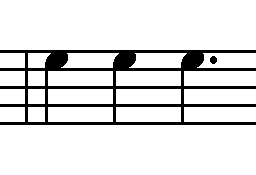

In [9]:
# generate_image()

In [45]:
# generate_images(30, savepath=Path('/home/macosta/ttmp/generated-columnwise/'))

100%|███████████████████████████████████████████| 30/30 [01:54<00:00,  3.81s/it]


In [49]:
generate_long_images(30, savepath=Path('/home/macosta/ttmp/generated-columnwise-long/'))

 17%|██████████████▎                                                                       | 170/1024 [00:20<01:41,  8.44it/s]


KeyboardInterrupt: 